This page includes python code derived from the code that was used to generate these figures. Again, you will see just how troublesome the limitations of existing platforms in handling projections intelligently can be. Some of the code is a bit overwhelming, so I've hidden most of it by default, but you can see it by clicking **&#9658; Code** to view the code blocks. 

In [1]:
#| code-fold: true
import math
import pandas
import numpy
import networkx
import geopandas
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from shapely.geometry import Point
from shapely.geometry import MultiPoint
from shapely.geometry import Polygon

%matplotlib inline 
import matplotlib.pyplot as plt

## The base data
This is dataset 11 from the site linked [here](links-6.qmd#footnote-6) and shows the numbers of offices of 100 major firms that exist in a collection of 315 cities. The network we build is based on shared offices of firms, i.e. if two cities both have offices of the same firm, then we consider them related. To avoid a very dense network, we require the presence of a firm in a city to have been rated at least 4 (on a 5 point scale) in the dataset.

First we read the data and have a look at it.

In [2]:
wcn = pandas.read_csv("da11-1.csv", index_col = 0)
wcn.head(5)

,Ernst & Young,Arthur Andersen,MSI,IGAF,AGN,BDO,Grant Thornton,Horwath,KPMG,Summit & Baker,...,Mercer,Boston,Deloitte,BoozeA&M,A.T. Kearney,McKinsey,Bain,Compass,Andersen Consulting,Gemini
name,,,,,,,,,,,,,,,,,,,,,
ABERDEEN,2,0,0,0,0,0,0,2,2,0,...,0,0,0,0,0,0,0,0,0,0
ABIJAN,3,0,0,0,0,0,0,0,2,0,...,0,0,2,0,0,0,0,0,0,0
ABU DHABI,2,2,0,0,2,0,0,2,2,0,...,0,0,2,2,0,0,0,0,2,0
ACCRA,0,0,0,0,0,0,2,0,2,0,...,0,0,2,0,0,0,0,0,0,0
ADDIS ABABA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Making the data into a network
The two functions in the code block below enable us to apply the 'minimum score 4' filter to the raw data, and then using matrix multiplication to convert the table into the adjacency matrix of a graph. This is based on the idea that an *incidence matrix*, $\mathbf{B}$, which the table is, can be multiplied by its transpose to yield an adjacency matrix, $\mathbf{A}$:

$$\mathbf{A}=\mathbf{B}\mathbf{B}^{\mathrm{T}}$$

In [3]:
#| code-fold: true

def cut_table_at(table: pandas.DataFrame, x: int) -> pandas.DataFrame:
    tbl = table.copy()
    tbl[tbl[:] < x] = 0  # remove cases < x
    tbl[tbl[:] > 0] = 1  # set all remaining to 1
    return tbl[list(tbl.sum(axis = 1) > 0)]  # remove rows with no non-0 values

def make_network_from_incidence_table(tbl: pandas.DataFrame) -> networkx.Graph:
    incidence_matrix = numpy.array(tbl)
    adj_matrix = incidence_matrix.dot(incidence_matrix.transpose())
    numpy.fill_diagonal(adj_matrix, 0)
    G = networkx.Graph(adj_matrix)
    return networkx.relabel_nodes(G, dict(zip(G.nodes(), list(tbl.index))))

## The geography
Below, we use the previous functions to form the graph, and then add longitude-latitude coordinates for each city to the nodes.


In [4]:
Gnx = make_network_from_incidence_table(cut_table_at(wcn, 4))

wcn_ll = pandas.read_csv("wcn-cities-ll.csv", index_col=0)

for name in Gnx.nodes():
    lon = wcn_ll.loc[name]["LONGITUDE"]
    lat = wcn_ll.loc[name]["LATITUDE"]
    Gnx.nodes[name]["lat"] = lat
    Gnx.nodes[name]["lon"] = lon

### A bad map
At this point, we can make up a naïve map (i.e. Figure 6.5a), simply connecting the end point coordinates of each edge in the graph with straight lines.


(-19844105.265762024,
 19844105.265762024,
 -9922052.632687533,
 9922052.632687533)

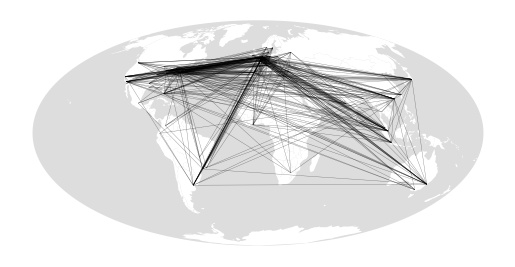

In [5]:
city_to_city = []
for e in Gnx.edges():
    p1 = Point(Gnx.nodes[e[0]]["lon"], Gnx.nodes[e[0]]["lat"])
    p2 = Point(Gnx.nodes[e[1]]["lon"], Gnx.nodes[e[1]]["lat"])
    city_to_city.append(LineString([p1, p2]))

# make up the naive links linestring dataset
city_to_city_gdf = geopandas.GeoDataFrame(
  geometry = geopandas.GeoSeries(city_to_city))
city_to_city_gdf.crs = "+proj=longlat"

moll = "+proj=moll"
# make up a 'globe' polygon for the background to the world maps
globe = Polygon(
  [Point(-180, y) for y in [_ / 10 for _ in range(-900, 901)]] + \
  [Point( 180, y) for y in [_ / 10 for _ in range(900, -901, -1)]])
globe_gdf = geopandas.GeoDataFrame(geometry = geopandas.GeoSeries([globe]))
globe_gdf.crs = "+proj=longlat"

# get countries data
countries = geopandas.read_file("ne-world.gpkg")

# and make up a map
ax = globe_gdf.to_crs(moll).plot(fc = "#dddddd")
countries.to_crs(moll).plot(ax = ax, fc = "w", linewidth = 0)
city_to_city_gdf.to_crs(moll).plot(ax = ax, color = "k", 
                                   alpha = 0.5, linewidth = 0.25)
plt.axis("off")

### The world is not flat
That map is not very useful, although avoiding making this kind of nonsense map is surprisingly difficult&mdash;another consequence of the limitations of how projections are handled in contemporary platforms. Things get complicated though... you have been warned...

So, we need several functions. First, the great circle distance beween two longitude-latitude points.


In [6]:
#| code-fold: true

# Uses the Haversine formulae, see
# https://en.wikipedia.org/wiki/Haversine_formula
def get_great_circle_distance(p1: Point, p2: Point,
                              R: float = 6378.137) -> float:
    lon0 = math.radians(p1.x)
    lat0 = math.radians(p1.y)
    lon1 = math.radians(p2.x)
    lat1 = math.radians(p2.y)
    dlon = lon1 - lon0
    dlat = lat1 - lat0
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + \
        math.cos(lat0) * math.cos(lat1) * \
        math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return (R * c)

Next, a function to return a great circle line (geodesic) between two points.

In [7]:
#| code-fold: true

def interpolate_between(z1: float, z2: float, steps: int) -> list[float]:
    fractions = [(1 + x) / steps for x in range(steps - 1)]
    return [z1] + [(z2 - z1) * f for f in fractions] + [z2]

def get_geodesic(p1: Point, p2: Point, step_length: int = 10) -> LineString:
    dist = get_great_circle_distance(p1, p2)
    # determine number of steps
    n_steps = math.ceil(dist / step_length) 
    # reproject in a space where great circles are straight lines
    gdf = geopandas.GeoDataFrame(geometry = geopandas.GeoSeries([p1, p2]))
    gdf.crs = "+proj=longlat"
    gdf = gdf.to_crs(f"+proj=aeqd +lon_0={p1.x} +lat_0={p1.y}")
    np1x, np1y = gdf.geometry[0].x, gdf.geometry[0].y
    np2x, np2y = gdf.geometry[1].x, gdf.geometry[1].y
    xs = interpolate_between(np1x, np2x, n_steps)
    ys = interpolate_between(np1y, np2y, n_steps)
    ngdf = geopandas.GeoDataFrame(geometry = geopandas.GeoSeries(
        Point(x, y) for x, y in zip(xs, ys)))
    ngdf.crs = f"+proj=aeqd +lon_0={p1.x} +lat_0={p1.y}"
    points = list(ngdf.to_crs("+proj=longlat").geometry)
    return LineString((p.x, p.y) for p in points) 

Next, a function that takes geodesic and breaks itat any point where there is large apparent jump between consecutive points. Here we use the naïve distance measurement based on the coordinates. This will mean the line is broken at the antimeridian.


In [8]:
#| code-fold: true

def split_at_antimeridian(geodesic: LineString) -> \
        MultiLineString|MultiPoint|LineString:
    points = geodesic.coords
    # make into a series of LineStrings
    segments = [LineString([p1, p2]) 
                   for p1, p2 in zip(points[:-1], points[1:])]
    lengths = [ls.length for ls in segments]
    intersections = [l > 1 for l in lengths]
    if True in intersections:
        idx = intersections.index(True)
        coords1 = points[:idx]
        coords2 = points[idx+1:]
        if len(coords1) > 1 and len(coords2) > 1:
            return MultiLineString([coords1, coords2])
        elif len(coords1) == 1 and len(coords2) == 1:
            return MultiPoint(points)
        else:
            if len(coords1) > len(coords2):
                return LineString(coords1)
            else:
                return LineString(coords2)
    else:
        return LineString(points)

### Make geodesic datasets between the cities

In [9]:
#| code-fold: true

geodesics = [] # list of LineStrings along the geodesic
cut_geodesics = [] # list of the geodesics cut at the dateline

# iterate over the edges
for e in Gnx.edges():
  p1 = Point(Gnx.nodes[e[0]]["lon"], Gnx.nodes[e[0]]["lat"])
  p2 = Point(Gnx.nodes[e[1]]["lon"], Gnx.nodes[e[1]]["lat"])
  g = get_geodesic(p1, p2)
  geodesics.append(g)
  cut_geodesics.append(split_at_antimeridian(g))

geodesics_gdf = geopandas.GeoDataFrame(
  geometry = geopandas.GeoSeries(geodesics))
geodesics_gdf.crs = "+proj=longlat"

geodesics_cut_gdf = geopandas.GeoDataFrame(
  geometry = geopandas.GeoSeries(cut_geodesics))
geodesics_cut_gdf.crs = "+proj=longlat"

## Mollweide fail maps
More maps that don't quite work. The first of these doesn't break the great circle links at the anti-meridian (dateline) so we get 'parallels' from one side of the map to the other when one crosses the anti-meridian. The second


(-19844105.265762024,
 19844105.265762024,
 -9922052.632687533,
 9922052.632687533)

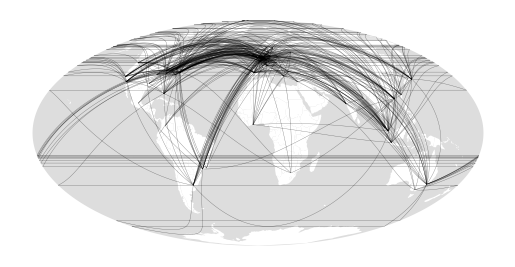

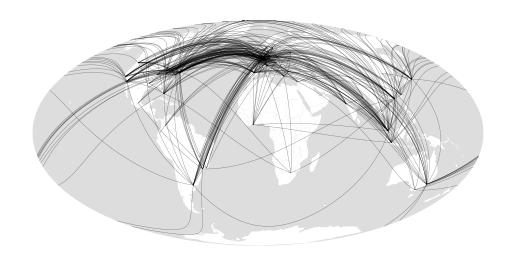

In [10]:
#| code-fold: true

ax = globe_gdf.to_crs(moll).plot(fc = "#dddddd")
countries.to_crs(moll).plot(ax = ax, fc = "w", linewidth = 0)
geodesics_gdf.to_crs(moll).plot(ax = ax, color = "k", 
                                alpha = 0.5, linewidth = 0.25)
plt.axis("off")

ax = globe_gdf.to_crs(moll).plot(fc = "#dddddd")
countries.to_crs(moll).plot(ax = ax, fc = "w", linewidth = 0)
geodesics_cut_gdf.to_crs(moll).plot(ax = ax, color = "k", 
                                    alpha = 0.5, linewidth = 0.25)
plt.axis("off")

## Orthographic not so fail maps


(-7015950.7, 7015950.7, -6992427.545669697, 6992427.545669697)

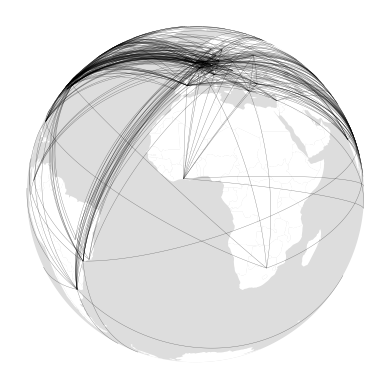

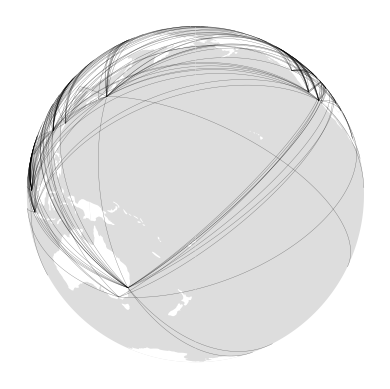

In [11]:
#| code-fold: true

atlantic = "+proj=ortho +lon_0=0 +lat_0=0"
pacific = "+proj=ortho +lon_0=180 +lat_0=0"
half_globe = globe_gdf.copy()
half_globe.geometry = half_globe.geometry.scale(xfact = 0.5)

countries_a = geopandas.read_file("atlantic.gpkg").to_crs(atlantic)
countries_p = geopandas.read_file("pacific.gpkg").to_crs(pacific)

ax = half_globe.to_crs(atlantic).plot(fc = "#dddddd")
countries_a.to_crs(atlantic).plot(ax = ax, fc = "w", linewidth = 0)
geodesics_cut_gdf.to_crs(atlantic).plot(ax = ax, color = "k",
                                        alpha = 0.5, linewidth = 0.25)
plt.axis("off")

ax = half_globe.to_crs(pacific).plot(fc = "#dddddd")
countries_p.to_crs(pacific).plot(ax = ax, fc = "w", linewidth = 0)
geodesics_cut_gdf.to_crs(pacific).plot(ax = ax, color = "k", 
                                       alpha = 0.5, linewidth = 0.25)
plt.axis("off")